# Using Machine Learning Algorithms

We will try and compare the algorithms listed in the [litterature review](index.ipynb#litterature-review). Namely, we will fit and compare the following algorithms, for both regression and classification tasks (on the *num_classes*, *variety* and *Chl* variables of the 3cl dataset):

- Partial Least Squares (PLS)
- Random Forests


For all algorithms, we will follow the same evaluation process:
1. Split the dataset into training (80%) and test (20%) sets
2. Use k-fold cross validation on the training set to avoid overfitting / tuning the hypermarameters
3. Evaluate performance using metrics such as R² for regression, and accuracy, precision, recall, F1 score, and confusion matrix for classification.

Some additional steps could be necessary for some combination of task / algorithms.

Before anything, we will need to import the data, and split it into training and test sets.


In [13]:

import sys
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, r2_score,classification_report
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


import matplotlib.pyplot as plt
import numpy as np



# Get current notebook path
notebook_path = Path.cwd()
# Go up one level to reach project root
project_root = notebook_path.parent
sys.path.insert(0, str(project_root))

from src.model_evaluation import ModelEvaluator

spectra = pd.read_csv(
    Path(project_root / "data/3cl/spectra_3cl.csv"), sep=";", index_col=0
)

# Load the classes data
labels = pd.read_csv(
    Path(project_root / "data/3cl/classes_3cl.csv"), sep=";", index_col=False
).reset_index(drop=True)

# Load the metadata data
interests = pd.read_csv(
    Path(project_root / "data/3cl/dt_leaves.csv"), sep=";", index_col=False
).reset_index(drop=True)

# Import transformers
from scripts.dataLoading import snv_transformer, sg_smoother, derivative1, derivative2

# Apply SNV followed by SG smoothing
X_snv_sg = sg_smoother.fit_transform(snv_transformer.fit_transform(spectra.values))

# Apply first and second derivatives
X_deriv1 = derivative1.fit_transform(spectra.values)
X_deriv2 = derivative2.fit_transform(spectra.values)

# Concatenate all transformed features
X = pd.DataFrame(np.concatenate([X_snv_sg, X_deriv1, X_deriv2], axis=1))
y = pd.concat([labels, interests], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


## Regression on *Chl*

Both algorithms can be used to make a prediction on the *Chl* value. The PLS need a scaling (per variable), to avoid that a generally high value wavelength "overshadowed" another generally lower wavelength. It is sensible to the scale of the variable, the same way the ACP is.

Here is an array showing the classic metrics used for regression.

| Metric                              | Definition                                                                                     | Formula                                                                 | Documentation                                                                 |
|-------------------------------------|------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| **explained_variance**             | Proportion of variance explained by the model.                                                 | $(1 - \frac{\text{Var}(y - \hat{y})}{\text{Var}(y)})$                  | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html) |
| **r2**                             | Coefficient of determination (R²).                                                             | $(1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2})$        | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) |
| **neg_mean_absolute_error**        | Negative mean of absolute errors.                                                              | $(-\frac{1}{n} \sum \|y_i - \hat{y}_i\|)$                              | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) |
| **neg_mean_squared_error**         | Negative mean of squared errors.                                                               | $(-\frac{1}{n} \sum (y_i - \hat{y}_i)^2)$                              | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) |
| **neg_root_mean_squared_error**    | Negative root of mean squared errors.                                                          | $(-\sqrt{\frac{1}{n} \sum (y_i - \hat{y}_i)^2})$                       | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) |
| **neg_mean_squared_log_error**     | Negative mean of squared logarithmic errors.                                                   | $(-\frac{1}{n} \sum (\log(1+y_i) - \log(1+\hat{y}_i))^2)$              | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html) |
| **neg_median_absolute_error**      | Negative median of absolute errors.                                                            | $(-\text{median}(\|y_1 - \hat{y}_1\|, \dots, \|y_n - \hat{y}_n\|))$    | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html) |
| **neg_mean_absolute_percentage_error** | Negative mean of absolute percentage errors.                                              | $(-\frac{100}{n} \sum \left\| \frac{y_i - \hat{y}_i}{y_i} \right\|)$   | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) |

### Partial Least Square

The first step is to find the optimal hyperparameters set: in the case of the PLS, the hyperparameters is juste the nomber of latent components. We use the [cross validation technique](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to this purpose, randomly shuffling subsets of the train data into smaller train and test samples. This technique is used to prevent **overfitting**, and to pick hyperparameters which have a good behaviour in prediction in general, in opposition to perfectly predict our train sample.

For pedagogic purpose, I also put an iteration over all the metrics. It may be tempting to pick the metric giving the best result, but the metric's choice is a **decision** that have to be made by you.

**N.B:** Note that we made some choice of parameter when we pretreated the data, like the polynomial order or the order of the derivative. To be more exhaustive, we could add those as hyperparameters of our model, and include the pretreatment in the validation process.

In [14]:
y_test_chl = y_test["Chl"]
y_train_chl = y_train["Chl"]

regression_best_score = 0
regression_best_n_components = 0
regression_best_metric = "r2"

regression_metrics = [
    "explained_variance",
    "r2",
    "neg_mean_absolute_error",
    "neg_mean_squared_error",
    "neg_root_mean_squared_error",
    "neg_mean_squared_log_error",
    "neg_median_absolute_error",
    "neg_mean_absolute_percentage_error",
]

regression_score = []

# Create a list to store all results
for n_components in range(1, 20):
    for metric in regression_metrics:
        model = PLSRegression(n_components=n_components)

        cv_results = cross_validate(
            model,
            X_train,
            y_train_chl,
            cv=5,
            n_jobs=2,
            scoring=metric,
            return_train_score=True,
        )

        mean_test_score = np.mean(cv_results["test_score"])
        regression_score.append(
            {
                "mean_test_score": mean_test_score,
                "n_components": n_components,
                "metric": metric,
            }
        )

        if mean_test_score > regression_best_score:
            regression_best_score = mean_test_score
            regression_best_n_components = n_components
            regression_best_metric = metric

print(
    f"Best score: {regression_best_score} with {regression_best_metric} for {regression_best_n_components} components"
)

Best score: 0.8057904916438179 with explained_variance for 2 components


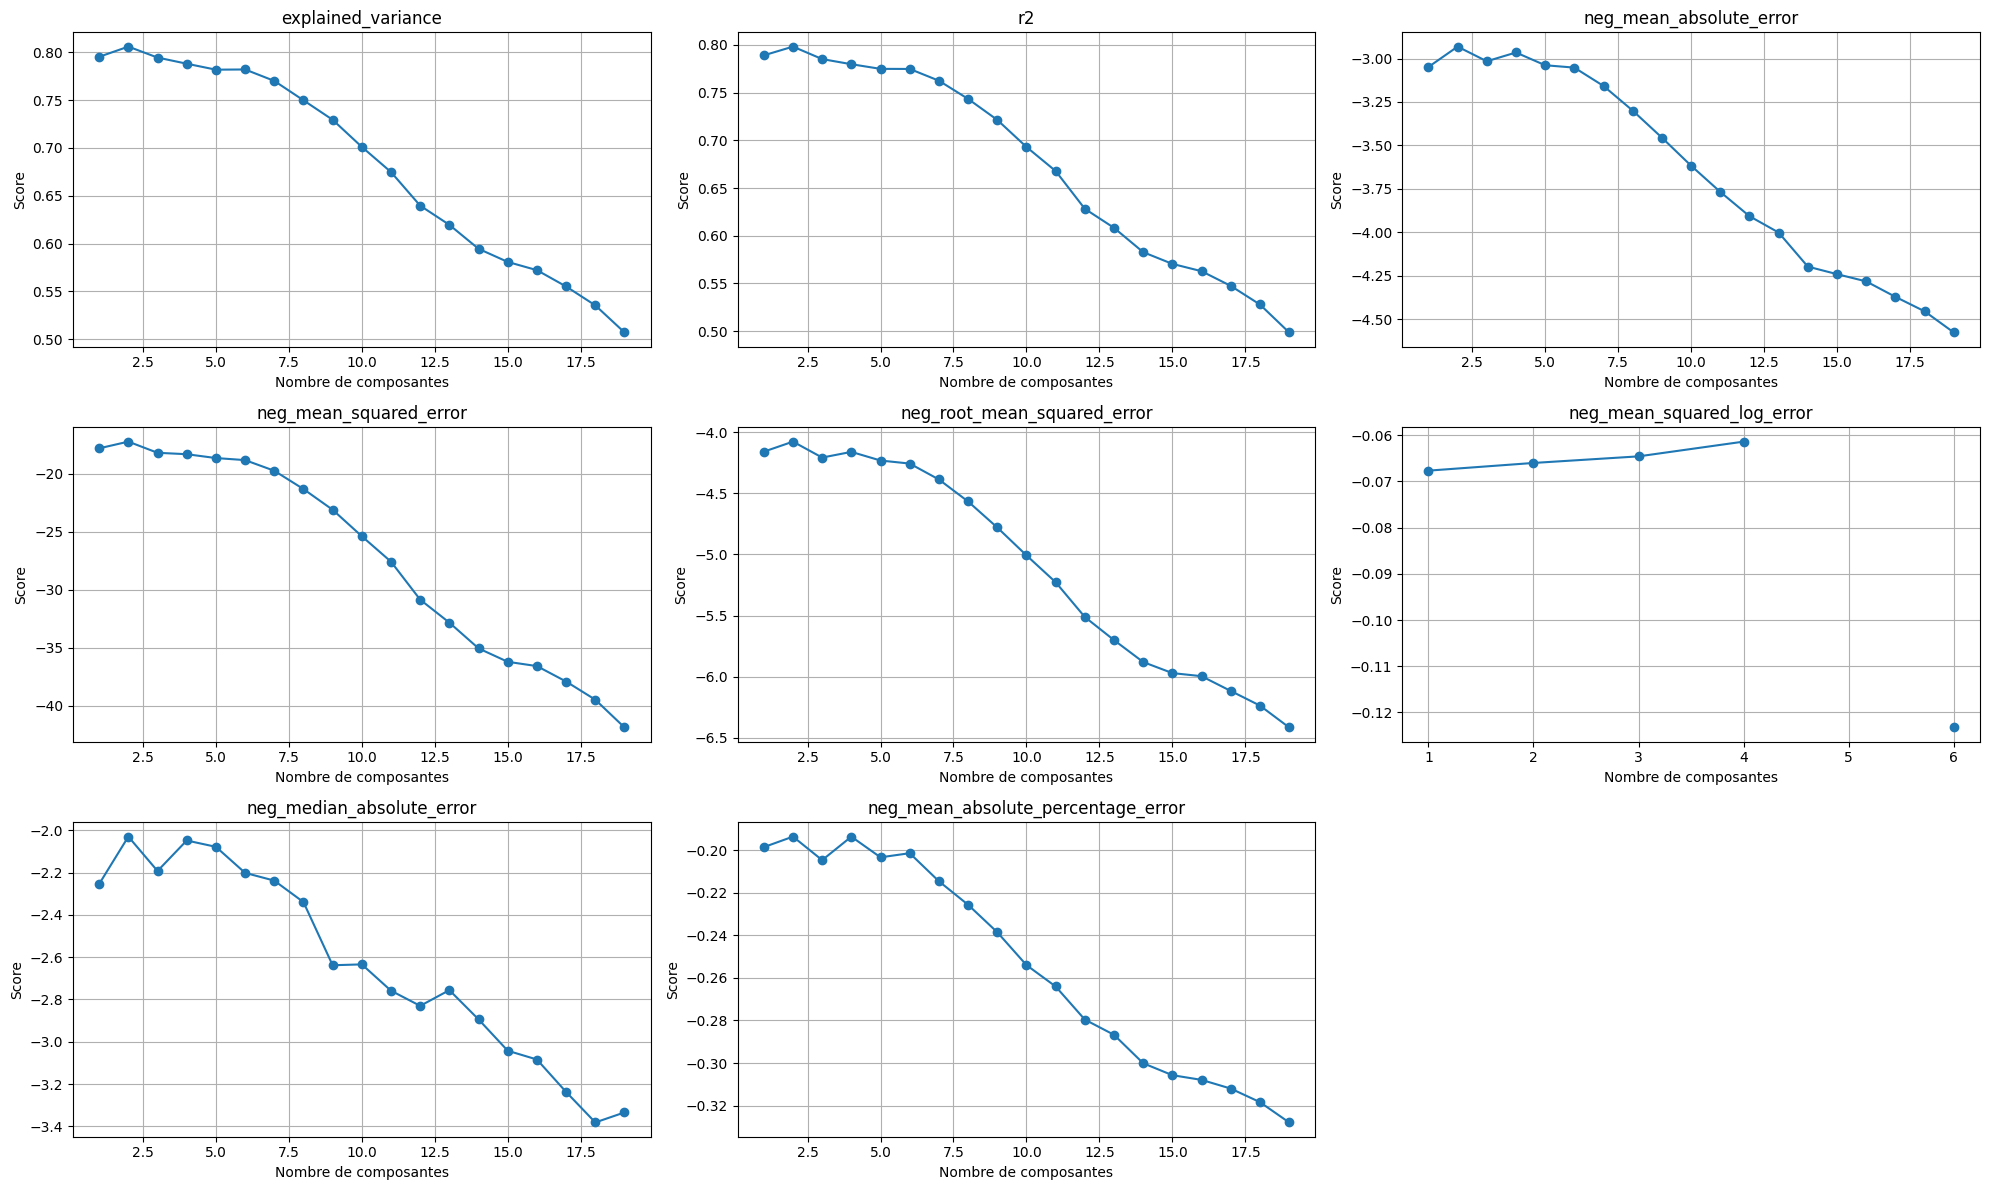

In [15]:

# Convert the results to a DataFrame for easier plotting
results_df = pd.DataFrame(regression_score)

# Create subplots for better organization of metrics
n_metrics = len(regression_metrics)
n_cols = 3
n_rows = (n_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Plot each metric in its own subplot
for idx, metric in enumerate(regression_metrics):
    metric_data = results_df[results_df["metric"] == metric]
    axes[idx].plot(
        metric_data["n_components"], metric_data["mean_test_score"], marker="o"
    )
    axes[idx].set_title(metric)
    axes[idx].set_xlabel("Nombre de composantes")
    axes[idx].set_ylabel("Score")
    axes[idx].grid(True)

# Remove empty subplots if any
for idx in range(len(regression_metrics), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


We can see that for any metrics we pick (in those shown), the optimal number of components is 2 for our problem, based on our dataset. In practice, r² is the most widely used indicator. The interpretation is that if we add more components to the PLS, we will specialize too much on the learning dataset so that we loose in general predictivity. 

Once we found the best hyperparameters, here being the number of components = 2, we can estimate the score of our model on the test sample, which the model has never seen yet.

R2 of the best model :  0.843772977103719

R² Scores Summary:
----------------------------------------
Chl                 : 0.844
No binary or categorical targets found in the dataset.

Regression metrics for Chl:
----------------------------------------
R²: 0.844
RMSE: 3.371
MAE: 2.613


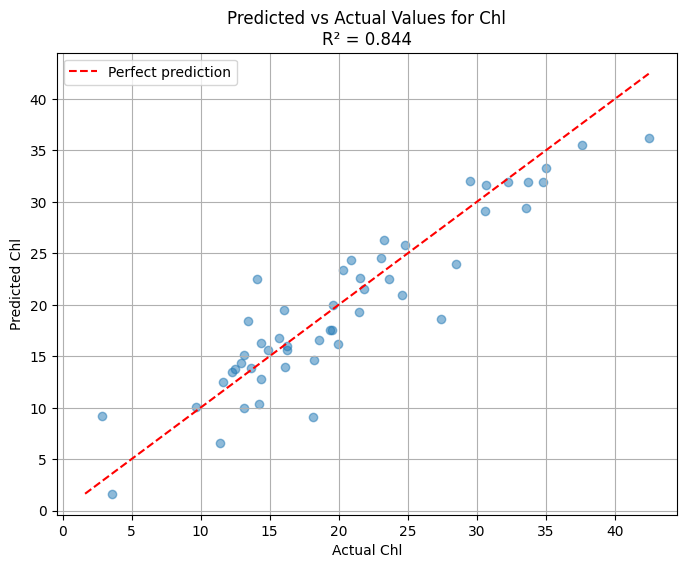

In [24]:
# Use the best number of components to train a model
model = PLSRegression(n_components=regression_best_n_components)
model.fit(X_train, y_train_chl)

# Use the model to predict the test set
reg_y_pred = model.predict(X_test)

# Print the accuracy of the model
print("R2 of the best model : ", r2_score(y_test_chl, reg_y_pred))

# Plot the result using an helper function (provided)
evaluator = ModelEvaluator(
    y_true=pd.DataFrame(y_test_chl),
    y_pred=pd.DataFrame(reg_y_pred, columns=["Chl"]),
)

evaluator.evaluate_all()

On the test sample and the regression target Chl, PLS obtains a score of 0.84, which means 84% of the variance is explained (the maximum is 1, or 100%).

#### Features importance

We can plot the absolute value for the loadings of the first two axis, for example.
We can display the relative importance of the data variables by plotting the loadings weight for this particular variable.











C:\Users\Guilhem\AppData\Local\Temp\ipykernel_18132\96835207.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(feature_names, rotation=45, ha="right")  # Rotation des labels pour lisibilité


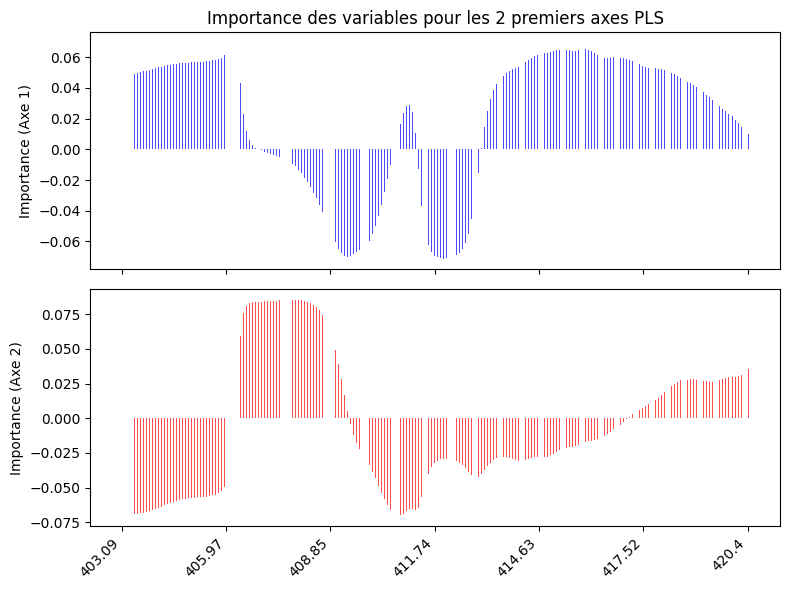

In [30]:
loadings = model.x_loadings_[:, :2]  # On garde les 2 premiers axes
feature_names = [float(val) for val in spectra.columns.tolist()]

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)  # Deux sous-graphiques partageant l'axe X

# Axe 1
axs[0].bar(feature_names, loadings[:len(spectra.columns), 0], color='b', alpha=0.7)
axs[0].set_ylabel("Importance (Axe 1)")
axs[0].set_title("Importance des variables pour les 2 premiers axes PLS")

# Axe 2
axs[1].bar(feature_names, loadings[:len(spectra.columns), 1], color='r', alpha=0.7)
axs[1].set_ylabel("Importance (Axe 2)")
axs[1].set_xticklabels(feature_names, rotation=45, ha="right")  # Rotation des labels pour lisibilité

plt.tight_layout()
plt.show()


### Random Forest

We can also use the random forest algorithm to predict a value instead of a class, by "voting" the value as beeing the mean of all the leaf obtain on the forest, each leaf being itself the mean value of its elements obtained during the fitting process.

The hyperparameters of the random forest are:
 - n_estimators: The number of trees in the forest. More trees generally improve performance but increase computation time
 - max_depth: The maximum depth of each tree. If None, nodes expand until all leaves are pure or contain less than min_samples_split samples
 - min_samples_split: The minimum number of samples required to split an internal node
 - min_samples_leaf: The minimum number of samples required to be at a leaf node

We choose to use the r² metric. We also fixed the ```n_estimators``` parameter to 500, because parameters only improve the stability of the model, not the performance. **Remamber** that random forest is an heuristic classifier, hence it has variability and we want to limit its variance.

In [17]:
metric = "r2"

cv_folds = 4
param_grid = {
    "n_estimators": [500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}



model = RandomForestRegressor()

grid_search = GridSearchCV(
    model, param_grid, cv=cv_folds, scoring=metric, n_jobs=-1
)

grid_search.fit(X_train, y_train_chl)

cv_results = grid_search.cv_results_
rf_regression_best_score = grid_search.best_score_
rf_regression_best_param = grid_search.best_params_


print(f"Best score: {rf_regression_best_score} for {rf_regression_best_param}")

Best score: 0.8065360760271588 for {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


The best set of hyperparameters found, in the grid we set, is ```{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}```. Since the dimension of the hyperparamters is not one, as it was for the PLS, we can use some pivot table to plot pairs of hyperparamters, for example :

Best score: 0.8065360760271588 for {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


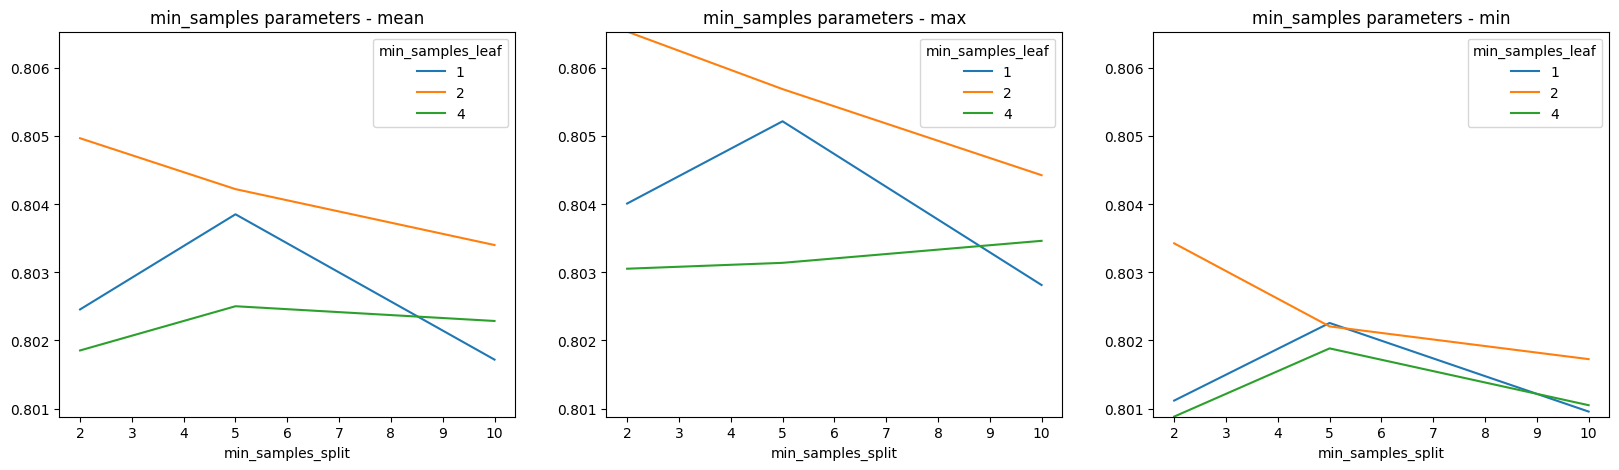

In [18]:
print(f"Best score: {rf_regression_best_score} for {rf_regression_best_param}")

# Extract data from cv_results
mean_scores = cv_results["mean_test_score"]

# Get the hyperparameters and their values
params = cv_results["params"]

# Create a dataframe for easier plotting
df_scores = pd.DataFrame(
    {
        "mean_test_score": mean_scores,
        **{param: [p[param] for p in params] for param in param_grid.keys()},
    }
)

# Plot the best parameter combinations
best_idx = df_scores["mean_test_score"].idxmax()
best_params = df_scores.loc[best_idx]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Calculate global min and max across all aggregation functions
y_min = float('inf')
y_max = float('-inf')
pivot_tables = []

for aggregator_function in ['mean', 'max', 'min']:
    pivot_data = df_scores.pivot_table(
        index="min_samples_split",
        columns="min_samples_leaf", 
        values="mean_test_score",
        aggfunc=aggregator_function,
    )
    pivot_tables.append(pivot_data)
    y_min = min(y_min, pivot_data.values.min())
    y_max = max(y_max, pivot_data.values.max())

# Plot with shared y-axis limits
for idx, (pivot_data_1, aggregator_function) in enumerate(zip(pivot_tables, ['mean', 'max', 'min'])):
    pivot_data_1.plot(ax=axes[idx])
    axes[idx].set_title(f"min_samples parameters - {aggregator_function}")
    axes[idx].set_ylim(y_min, y_max)
    

Notice that we could go deeper in the exploration of the best parameters, but we will stop here.

We could now fit and plot the result for the best random forest model for this dataset.

R2 of the best model :  0.8369025924990804

R² Scores Summary:
----------------------------------------
Chl                 : 0.837
No binary or categorical targets found in the dataset.

Regression metrics for Chl:
----------------------------------------
R²: 0.837
RMSE: 3.444
MAE: 2.384


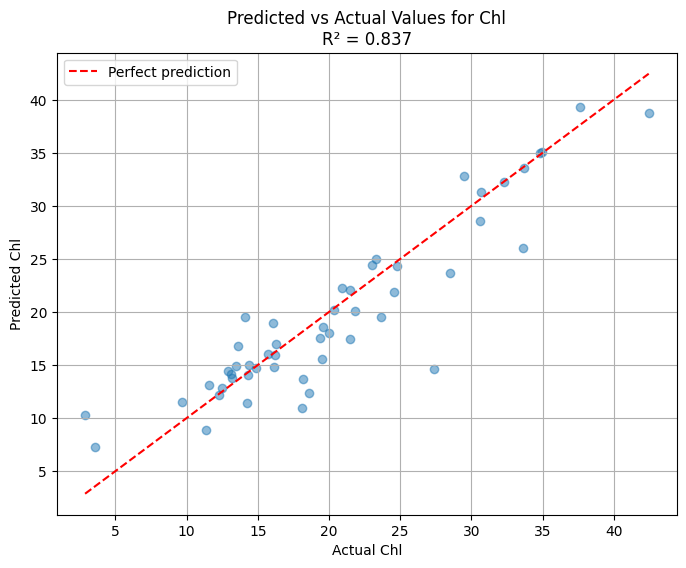

In [19]:
model = RandomForestRegressor(**rf_regression_best_param)
model.fit(X_train, y_train_chl)

# Use the model to predict the test set
reg_rf_y_pred = model.predict(X_test)

# Print the accuracy of the model
print("R2 of the best model : ", r2_score(y_test_chl, reg_rf_y_pred))

# Plot the result using an helper function (provided)
evaluator = ModelEvaluator(
    y_true=pd.DataFrame(y_test_chl),
    y_pred=pd.DataFrame(reg_rf_y_pred, columns=["Chl"]),
)

evaluator.evaluate_all()

It is important to note that the random forest is by construction "random". It means that running the code multiple time will lead to different fitted model, and thus different score.

#### Variable interest

We can display the importance of each feature, based on its overall use in optimizing the split criterion above all nodes of all trees.


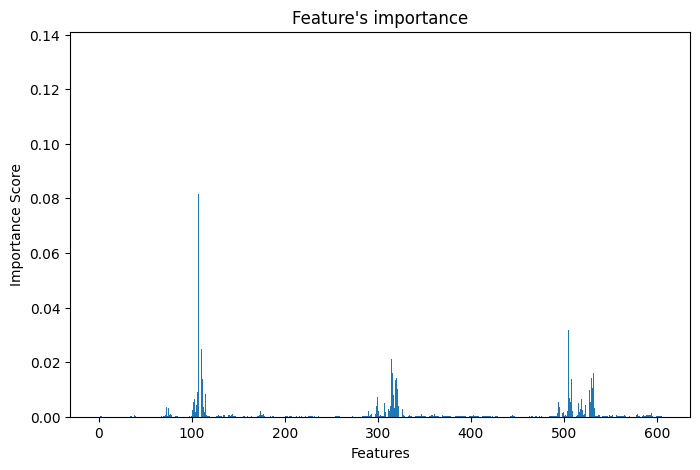

In [ ]:
plt.figure(figsize=(8, 5))
plt.title("Feature's importance")
plt.bar(range(X.shape[1]), model.feature_importances_, align="center")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


### Best regression model

As we have to pick the most relevant model purely for the regression task, for the variable Chl, we choose the RandomForestRegressor model.

## Classification on *num_classes* and *variety*

The main task of this study is to classify the leaves into 3 classes, based on their spectra. We will use the *num_classes* and *variety* variables for this task.

We will use the same process as for the regression task, but we will use a different metric, suited for classification. Here are the most common metrics used for classification:

| Metric                | scikit-learn Formula                                                                           | Documentation Link                                                                 | Notes                     |
|-----------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------|---------------------------|
| **Accuracy**          | $\frac{TP + TN}{TP + TN + FP + FN}$                                                           | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |                           |
| **Balanced Accuracy** | $\frac{1}{2}\left(\frac{TP}{TP + FN} + \frac{TN}{TN + FP}\right)$ (binary)                   | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) | For multiclass, averages recalls |
| **Precision Macro**   | $\frac{1}{\|L\|}\sum_{l \in L} \frac{TP_l}{TP_l + FP_l}$                                       | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) | $L$ = set of labels       |
| **Precision Micro**   | $\frac{\sum_{l \in L} TP_l}{\sum_{l \in L} (TP_l + FP_l)}$                                  | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |                           |
| **Precision Weighted**| $\sum_{l \in L} w_l \cdot \frac{TP_l}{TP_l + FP_l}$                                         | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) | $w_l$ = support of class $l$ |
| **Recall Macro**      | $\frac{1}{\|L\|}\sum_{l \in L} \frac{TP_l}{TP_l + FN_l}$                                       | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |                           |
| **Recall Micro**      | $\frac{\sum_{l \in L} TP_l}{\sum_{l \in L} (TP_l + FN_l)}$                                  | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |                           |
| **Recall Weighted**   | $\sum_{l \in L} w_l \cdot \frac{TP_l}{TP_l + FN_l}$                                         | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |                           |
| **F1 Macro**          | $\frac{1}{\|L\|}\sum_{l \in L} 2 \cdot \frac{P_l \cdot R_l}{P_l + R_l}$                       | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) | $P_l$=Precision, $R_l$=Recall |
| **F1 Micro**          | $2 \cdot \frac{P_{micro} \cdot R_{micro}}{P_{micro} + R_{micro}}$                            | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |                           |
| **F1 Weighted**       | $\sum_{l \in L} w_l \cdot 2 \cdot \frac{P_l \cdot R_l}{P_l + R_l}$                          | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |                           |
| **Jaccard Macro**     | $\frac{1}{\|L\|}\sum_{l \in L} \frac{TP_l}{TP_l + FP_l + FN_l}$                               | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) |                           |
| **Jaccard Micro**     | $\frac{\sum_{l \in L} TP_l}{\sum_{l \in L} (TP_l + FP_l + FN_l)}$                           | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) |                           |
| **Jaccard Weighted**  | $\sum_{l \in L} w_l \cdot \frac{TP_l}{TP_l + FP_l + FN_l}$                                  | [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) |                           |


As we have unbalanced dataset, both for the *num_classes* and *variety* variables, we will use the *balanced_accuracy* metric. 


In [23]:
y_train_num_classe = y_train["num_classe"]
y_test_num_classe = y_test["num_classe"]


### PLS for classification

The steps will be roughly the same as for the regression task. We will use the same process to find the best hyperparameters, but as PLS is a regression algorithm, we will need to transform the target variable into a one-hot encoded vector (a vector of 0 and 1, 1 beeing the appartenance to the class). This approach allow us to classify the leaves into 3 classes, without any false order relationship between them: each class is scored independently. We then choose the class with the highest score.

We could use both a classification metric on a "modified" PLS directly, or use the r² on the one-hot encoded target variable. I will show the second approach here, as it is simpler to understand, and doesn't need to build a custom model.



In [9]:

metric = "balanced_accuracy"

class_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
class_encoder.fit(y_train_num_classe.values.reshape(-1, 1))
y_train_num_classe_encoded = class_encoder.fit_transform(y_train_num_classe.values.reshape(-1, 1))

pls_classification_best_score = 0
param_grid = {
    "n_components": range(1, 18)
}
cv_folds = 4

model = PLSRegression()

grid_search = GridSearchCV(
    model, param_grid, cv=cv_folds, scoring="r2", n_jobs=-1
)

grid_search.fit(X_train, y_train_num_classe_encoded)

cv_results = grid_search.cv_results_
pls_classification_best_score = grid_search.best_score_
pls_classification_best_parameters = grid_search.best_params_

print(
    f"Best score: {pls_classification_best_score} for {pls_classification_best_parameters} parameters"
)

Best score: 0.3187449157572832 for {'n_components': 5} parameters


In [ ]:
# Use the best number of components to train a model
model = PLSRegression(n_components=pls_classification_best_parameters["n_components"])
model.fit(X_train, y_train_num_classe_encoded)

# Use the model to predict the test set
pls_classification_y_pred = class_encoder.inverse_transform(model.predict(X_test))

# Print the accuracy of the model
print("Accuracy on test: ", accuracy_score(y_test_num_classe, pls_classification_y_pred))

print("Balanced Accuracy on test: ", balanced_accuracy_score(y_test_num_classe, pls_classification_y_pred))
# Print the confusion matrix of the model
print(
    "Confusion matrix on test using regression on one-hot encoded target: \n",
    confusion_matrix(y_test_num_classe.values, pls_classification_y_pred),
)
print(classification_report(y_test_num_classe, pls_classification_y_pred))


Accuracy on test:  0.7450980392156863
Balanced Accuracy on test:  0.5881313131313132
Confusion matrix on test using regression on one-hot encoded target: 
 [[31  0  2]
 [ 5  2  3]
 [ 3  0  5]]
              precision    recall  f1-score   support

           1       0.79      0.94      0.86        33
           2       1.00      0.20      0.33        10
           3       0.50      0.62      0.56         8

    accuracy                           0.75        51
   macro avg       0.76      0.59      0.58        51
weighted avg       0.79      0.75      0.71        51



You can also use the ModelEvaluator, which does the same thing.


Classification metrics for num_classe:
----------------------------------------
              precision    recall  f1-score   support

           1       0.79      0.94      0.86        33
           2       1.00      0.20      0.33        10
           3       0.50      0.62      0.56         8

    accuracy                           0.75        51
   macro avg       0.76      0.59      0.58        51
weighted avg       0.79      0.75      0.71        51



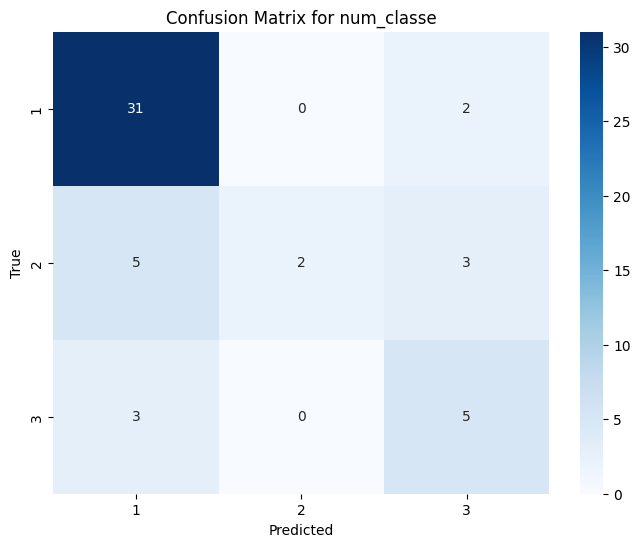

No continuous targets found in the dataset.


In [11]:
evaluator = ModelEvaluator(
    y_true=pd.DataFrame(y_test_num_classe, dtype="category"),
    y_pred=pd.DataFrame(pls_classification_y_pred, columns=["num_classe"], dtype="category"),
)

evaluator.evaluate_all()

With the optimal number of components, we obtain an accuracy of 0.74, and a balanced accuracy of 0.58. Note the difference between the accuracy and the balanced accuracy, which is due to the unbalanced dataset. The first class is overrepresented, and thus the accuracy is high, but the balanced accuracy is low: the model is not good at predicting the minority classes.

We can also plot the loadings weight for some insight


C:\Users\Guilhem\AppData\Local\Temp\ipykernel_18132\4094336212.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(feature_names, rotation=45, ha="right")  # Rotation des labels pour lisibilité


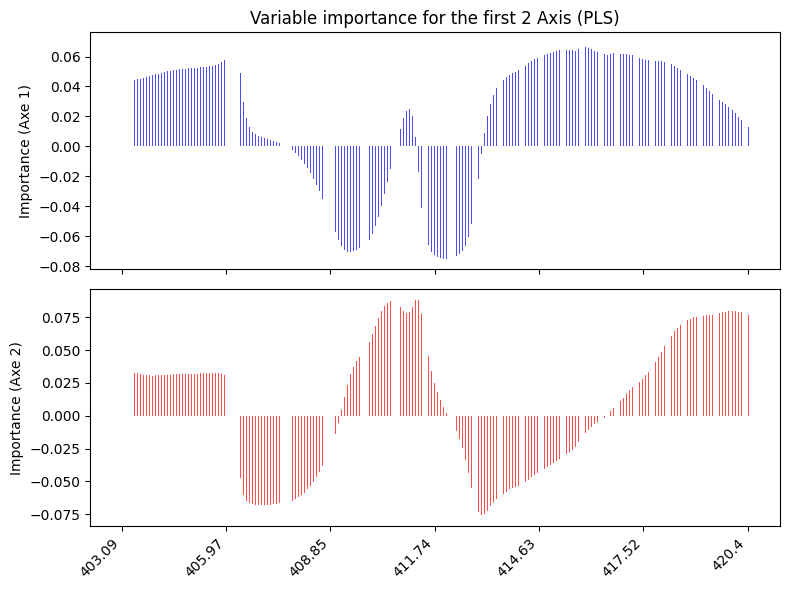

In [32]:
loadings = model.x_loadings_[:, :2]  # On garde les 2 premiers axes
feature_names = [float(val) for val in spectra.columns.tolist()]

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)  # Deux sous-graphiques partageant l'axe X

# Axe 1
axs[0].bar(feature_names, loadings[:len(spectra.columns), 0], color='b', alpha=0.7)
axs[0].set_ylabel("Importance (Axe 1)")
axs[0].set_title("Variable importance for the first 2 Axis (PLS)")

# Axe 2
axs[1].bar(feature_names, loadings[:len(spectra.columns), 1], color='r', alpha=0.7)
axs[1].set_ylabel("Importance (Axe 2)")
axs[1].set_xticklabels(feature_names, rotation=45, ha="right")  # Rotation des labels pour lisibilité

plt.tight_layout()
plt.show()


### Random Forest for classification



In [45]:
cv_folds = 4
param_grid = {
    "n_estimators": [500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}



model = RandomForestClassifier()

grid_search = GridSearchCV(
    model, param_grid, cv=cv_folds, scoring="accuracy", n_jobs=-1
)

grid_search.fit(X_train, y_train_num_classe)

cv_results = grid_search.cv_results_
rf_classification_best_score = grid_search.best_score_
rf_classification_best_param = grid_search.best_params_


print(f"Best score: {rf_classification_best_score} for {rf_classification_best_param}")


Best score: 0.8696018893387314 for {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


Accuracy on test:  0.7450980392156863
Balanced Accuracy on test:  0.5881313131313132

Classification metrics for num_classe:
----------------------------------------
              precision    recall  f1-score   support

           1       0.78      0.94      0.85        33
           2       1.00      0.20      0.33        10
           3       0.56      0.62      0.59         8

    accuracy                           0.75        51
   macro avg       0.78      0.59      0.59        51
weighted avg       0.78      0.75      0.71        51



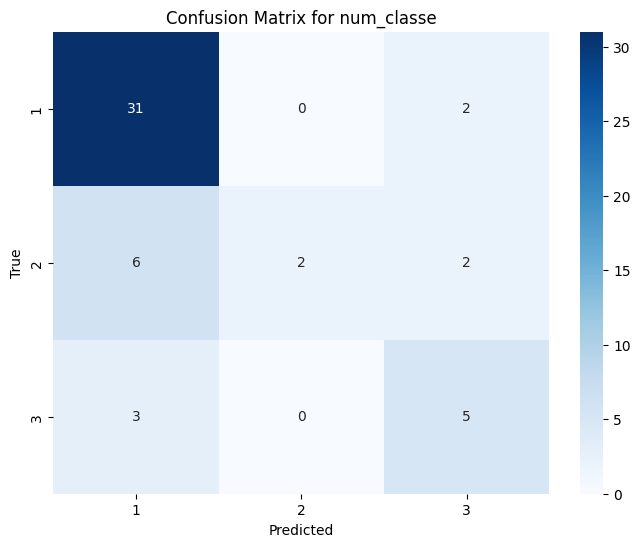

No continuous targets found in the dataset.


In [49]:
model = RandomForestClassifier(**rf_classification_best_param)
model.fit(X_train, y_train_num_classe)
# Use the model to predict the test set
rf_classification_y_pred = model.predict(X_test)

# Print the accuracy of the model
print("Accuracy on test: ", accuracy_score(y_test_num_classe, rf_classification_y_pred))

print("Balanced Accuracy on test: ", balanced_accuracy_score(y_test_num_classe, rf_classification_y_pred))
evaluator = ModelEvaluator(
    y_true=pd.DataFrame(y_test_num_classe, dtype="category"),
    y_pred=pd.DataFrame(rf_classification_y_pred, columns=["num_classe"], dtype="category"),
)

evaluator.evaluate_all()

The feature imporatnce can once agin be plotted;


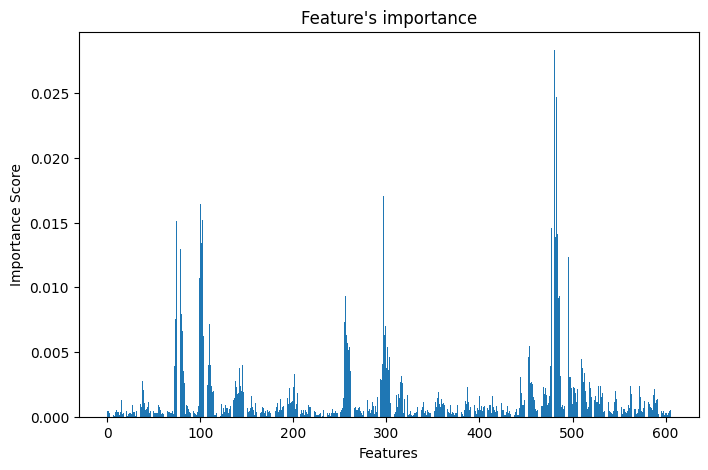

In [50]:
plt.figure(figsize=(8, 5))
plt.title("Feature's importance")
plt.bar(range(X_test.shape[1]), model.feature_importances_, align="center")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


### Best classification model

It seems that the two models are performing exactly the same. We can then choose the one that is the most interpretable, which is the RandomForestClassifier.
